In [1]:
# !pip install GDAL-3.1.4-cp39-cp39m-win_amd64.whl
# !pip install Fiona-1.8.17-cp39-cp39m-win_amd64.whl
# !pip install Shapely-1.7.1-cp39-cp39m-win_amd64.whl 
# !pip install geopandas

In [2]:
import geopandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy as copy
import warnings
import datetime
import plotly.express as px
import os
import matplotlib.patheffects as pe
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

<AxesSubplot:>

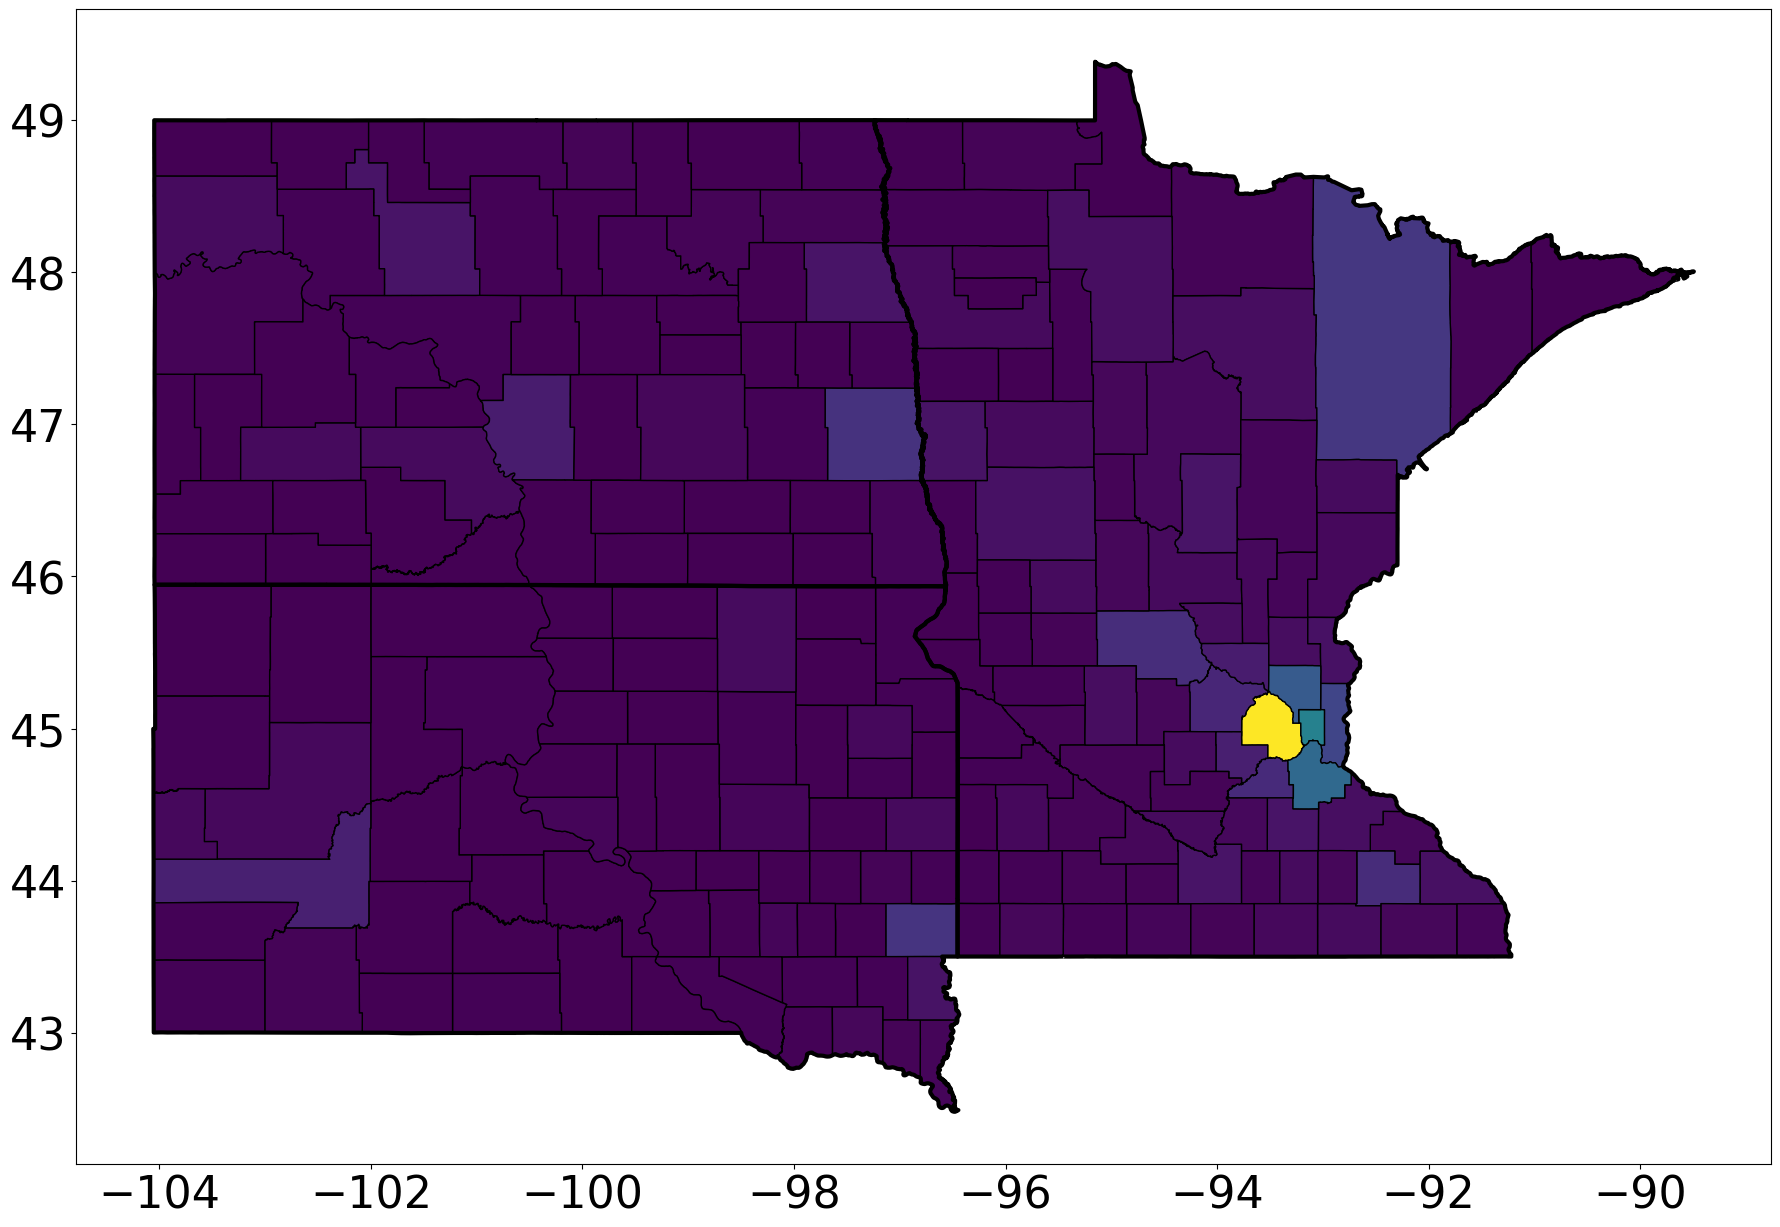

In [25]:
plt.rcParams.update({'font.size': 32})
filename = "countiesWithStatesAndPopulation.shp"
index_col = "FIPS"
map_data = geopandas.read_file(filename = filename).set_index(["State", 
                                                               "NAME"])
states = ["North Dakota", 
          "South Dakota", 
          "Minnesota"]
map_plot_data = map_data.loc[states]
state_df = map_plot_data.dissolve(by=["State"], aggfunc = "median")

fig, ax = plt.subplots(figsize = (30,15))
map_plot_data.plot(column = "Population", 
                   cmap = "viridis",
                   alpha = 1, 
                   edgecolor = "k",
                  ax = ax)
state_df.plot(color = "None", 
                  alpha = 1,
                  edgecolor = "k",
                  linewidth = 3,
                          ax = ax)

In [4]:
def import_geo_data(filename, FIPS_name = "FIPS"):
    map_data = geopandas.read_file(filename = filename).rename(
        columns = {"State":"state"})
    map_data[FIPS_name] = map_data["STATEFP"].astype(str) +\
        map_data["COUNTYFP"].astype(str)
    map_data[FIPS_name] = map_data[FIPS_name].astype(np.int64)
    map_data.set_index(FIPS_name, inplace = True)
    
    return map_data
map_data = import_geo_data(filename = filename, FIPS_name = index_col)
map_data

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,NAME,LSAD,ALAND,AWATER,Population,state,geometry
FIPS,,,,,,,,,,,
21007,21,007,00516850,0500000US21007,Ballard,06,639387454,69473325,7888.0,Kentucky,"POLYGON ((-89.18137 37.04630, -89.17938 37.053..."
21017,21,017,00516855,0500000US21017,Bourbon,06,750439351,4829777,19788.0,Kentucky,"POLYGON ((-84.44266 38.28324, -84.44114 38.283..."
21031,21,031,00516862,0500000US21031,Butler,06,1103571974,13943044,12879.0,Kentucky,"POLYGON ((-86.94486 37.07341, -86.94346 37.074..."
21065,21,065,00516879,0500000US21065,Estill,06,655509930,6516335,14106.0,Kentucky,"POLYGON ((-84.12662 37.64540, -84.12483 37.646..."
21069,21,069,00516881,0500000US21069,Fleming,06,902727151,7182793,14581.0,Kentucky,"POLYGON ((-83.98428 38.44549, -83.98246 38.450..."
...,...,...,...,...,...,...,...,...,...,...,...
31073,31,073,00835858,0500000US31073,Gosper,06,1186616237,11831826,1990.0,Nebraska,"POLYGON ((-100.09510 40.43866, -100.08937 40.4..."
39075,39,075,01074050,0500000US39075,Holmes,06,1094405866,3695230,43960.0,Ohio,"POLYGON ((-82.22066 40.66758, -82.19327 40.667..."
48171,48,171,01383871,0500000US48171,Gillespie,06,2740719114,9012764,26988.0,Texas,"POLYGON ((-99.30400 30.49983, -99.28234 30.499..."


<AxesSubplot:>

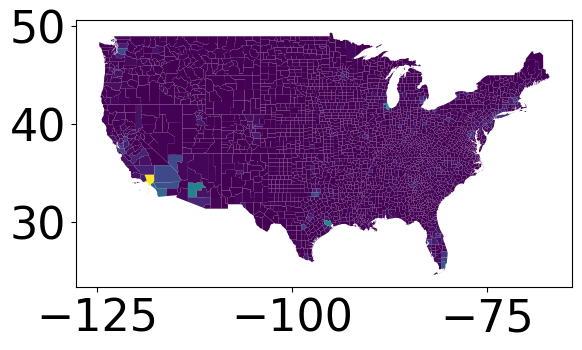

In [5]:
# plot only counties not in Hawaii or Alaska
map_data[~map_data["state"].isin(
    ["Hawaii", "Alaska"])].plot(column = "Population")

In [6]:
u_data = pd.read_csv("countyUnemploymentData.csv",
                    encoding = "latin1",
                    parse_dates = True,
                    index_col = ["date", "fips_code"])
u_data = u_data[list(u_data.keys())[-4:]]
u_data.dtypes

C:\Users\jacob\AppData\Local\Temp\ipykernel_13704\1701343223.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  u_data = pd.read_csv("countyUnemploymentData.csv",


Labor Force          object
Employed             object
Unemployed           object
Unemployment Rate    object
dtype: object

In [7]:
for key in u_data.keys():
    u_data[key] = pd.to_numeric(u_data[key], errors = "coerce")
u_data.dtypes

Labor Force          float64
Employed             float64
Unemployed           float64
Unemployment Rate    float64
dtype: object

In [8]:
def create_merged_geo_dataframe(data, map_data):
    data_frame_initialized = False
    matching_gpd = {}
    counties = data.groupby("fips_code").mean().index.unique()
    dates = data.groupby("date").mean().index.unique()
    for key, val in data.items():
        matching_gpd[key] = copy.copy(
            map_data[map_data.index.isin(counties)])
        for date in dates:
            val_slice = val.loc[date]
            val_slice.reset_index().set_index("fips_code")
            matching_gpd[key][date] = val_slice
    return matching_gpd

dates = u_data.groupby("date").mean().index.unique()
u_data = create_merged_geo_dataframe(u_data, map_data)

In [9]:
u_data["Unemployment Rate"]

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,NAME,LSAD,ALAND,AWATER,Population,state,...,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00,2021-06-01 00:00:00
FIPS,,,,,,,,,,,,,,,,,,,,,
21007,21,007,00516850,0500000US21007,Ballard,06,639387454,69473325,7888.0,Kentucky,...,4.7,4.9,5.2,5.7,5.3,5.3,5.5,4.0,4.3,5.8
21017,21,017,00516855,0500000US21017,Bourbon,06,750439351,4829777,19788.0,Kentucky,...,4.2,3.8,3.9,4.4,4.1,4.1,4.4,3.1,3.2,4.5
21031,21,031,00516862,0500000US21031,Butler,06,1103571974,13943044,12879.0,Kentucky,...,4.9,4.6,4.6,5.1,5.1,5.1,4.9,3.4,3.9,5.5
21065,21,065,00516879,0500000US21065,Estill,06,655509930,6516335,14106.0,Kentucky,...,5.6,5.3,5.3,6.0,5.9,5.7,5.8,4.1,4.5,6.2
21069,21,069,00516881,0500000US21069,Fleming,06,902727151,7182793,14581.0,Kentucky,...,5.0,4.6,4.7,5.6,5.6,5.9,5.5,4.0,4.2,5.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31073,31,073,00835858,0500000US31073,Gosper,06,1186616237,11831826,1990.0,Nebraska,...,2.0,1.9,1.8,1.5,1.7,2.0,1.8,1.7,1.8,1.9
39075,39,075,01074050,0500000US39075,Holmes,06,1094405866,3695230,43960.0,Ohio,...,3.2,2.0,2.1,2.6,3.1,3.1,2.4,2.1,2.6,3.8
48171,48,171,01383871,0500000US48171,Gillespie,06,2740719114,9012764,26988.0,Texas,...,4.5,3.9,3.9,3.8,4.4,4.4,4.3,3.7,3.7,4.1


In [10]:
dates

DatetimeIndex(['2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01',
               '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01',
               '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
               '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01',
               '2021-04-01', '2021-05-01', '2021-06-01'],
              dtype='datetime64[ns]', name='date', freq=None)

In [11]:
# matplotlib will give us warning because we are setting the value a slice
warnings.filterwarnings("ignore")
# Normalize Unemployment Feb-20 == 1
key = "Unemployment Rate"
new_key = "Normalized " + key + " (Feb 2020)"
# df.copy() makes a copy of the dataframe
u_data[new_key] = u_data[key].copy()
# take the difference between the observed rate and the Feb rate
for date in dates:
    u_data[new_key][date] = u_data[key][date].sub(
        u_data[key][datetime.datetime(2020,2,1)])

In [12]:
new_key

'Normalized Unemployment Rate (Feb 2020)'

In [28]:
key = "Unemployment Rate"
plot_data = u_data["Unemployment Rate"].copy()
plot_data = plot_data[~plot_data["state"].isin(["Hawaii", "Alaska"])]
state_df = plot_data.dissolve(by = ["state"], aggfunc = "median")

'''
for date in dates:
    fig, ax = plt.subplots(figsize = (40,20))
    # dissolve performs groupby operation and aggregates geoids to the level
    # grouped by

    # COLOR SETTINGS
    vmin = 0
    vmax = 20
    # choose color bar format (which colors? how many divisions?)
    cmap = cm.get_cmap("Reds", 8)
    # choose range of color bar values
    norm = cm.colors.Normalize(vmin = vmin, vmax = vmax)
    sm = cm.ScalarMappable(cmap = cmap, norm = norm)
    # prepare space for colorbar on fig
    divider = make_axes_locatable(ax)
    size = "5%"
    cax = divider.append_axes("right", 
                              size = size, 
                              pad = .1)
    # add colorbar to space in fig
    cbar = fig.colorbar(sm, cax = cax, cmap = cmap)
    cbar.ax.tick_params(labelsize = 18)
    vals = list(cbar.ax.get_yticks())
    # append max values from plot_df[dates] to vals for cbar
    vals.append(plot_data[dates].max().max())
    cbar.ax.set_yticklabels(vals)
    cbar.ax.set_ylabel(key, fontsize = 20)
    
    plot_data.plot(ax = ax, 
                cax = ax,
                column = date,
                cmap = cmap, legend = False,
                linewidth = .5, edgecolor = "white",
                norm = norm)
    state_df.plot(color = "None", 
                  alpha = 1,
                  edgecolor = "k",
                  linewidth = 3,
                  ax = ax)
    ax.set_title(str(date)[:10] + "\n" + key)  
'''    

'\nfor date in dates:\n    fig, ax = plt.subplots(figsize = (40,20))\n    # dissolve performs groupby operation and aggregates geoids to the level\n    # grouped by\n\n    # COLOR SETTINGS\n    vmin = 0\n    vmax = 20\n    # choose color bar format (which colors? how many divisions?)\n    cmap = cm.get_cmap("Reds", 8)\n    # choose range of color bar values\n    norm = cm.colors.Normalize(vmin = vmin, vmax = vmax)\n    sm = cm.ScalarMappable(cmap = cmap, norm = norm)\n    # prepare space for colorbar on fig\n    divider = make_axes_locatable(ax)\n    size = "5%"\n    cax = divider.append_axes("right", \n                              size = size, \n                              pad = .1)\n    # add colorbar to space in fig\n    cbar = fig.colorbar(sm, cax = cax, cmap = cmap)\n    cbar.ax.tick_params(labelsize = 18)\n    vals = list(cbar.ax.get_yticks())\n    # append max values from plot_df[dates] to vals for cbar\n    vals.append(plot_data[dates].max().max())\n    cbar.ax.set_yticklabe

In [29]:
key = new_key
plot_data = u_data[key].copy()
plot_data = plot_data[~plot_data["state"].isin(["Hawaii", "Alaska"])]
state_df = plot_data.dissolve(by=["state"], aggfunc = "median")

'''
for date in dates:
    fig, ax = plt.subplots(figsize = (40,20))
    # dissolve performs groupby operation and aggregates geoids to the
    #  level grouped by

    vmin = -20
    vmax = 20
    # choose color bar format (which colors? how many divisions?)
    cmap = cm.get_cmap("coolwarm", 15)
    # choose range of color bar values
    norm = cm.colors.Normalize(vmin = vmin, vmax = vmax)
    sm = cm.ScalarMappable(cmap = cmap, norm = norm)
    # prepare space for colorbar on fig
    divider = make_axes_locatable(ax)
    size = "5%"
    cax = divider.append_axes("right", 
                              size = size, 
                              pad = 0.1)
    # add colorbar to space in fig
    cbar = fig.colorbar(sm, cax = cax, cmap = cmap)
    cbar.ax.tick_params(labelsize = 18)
    vals = list(cbar.ax.get_yticks())
    # append max values from plot_df[dates] to vals for cbar
    vals.append(plot_data[dates].max().max())
    cbar.ax.set_yticklabels(vals)
    cbar.ax.set_ylabel(key, fontsize = 20)
    plot_data.plot(ax = ax, 
            cax = ax,
           column = date,
           cmap = cmap, legend = False,
           linewidth = 0.5, edgecolor = "white",
           norm = norm)

    state_df.plot(color = "None", 
                  alpha = 1,
                  edgecolor = "k",
                  linewidth = 5,
                  ax = ax)
    ax.set_title(str(date)[:10] + "\n" + key)
'''

'\nfor date in dates:\n    fig, ax = plt.subplots(figsize = (40,20))\n    # dissolve performs groupby operation and aggregates geoids to the\n    #  level grouped by\n\n    vmin = -20\n    vmax = 20\n    # choose color bar format (which colors? how many divisions?)\n    cmap = cm.get_cmap("coolwarm", 15)\n    # choose range of color bar values\n    norm = cm.colors.Normalize(vmin = vmin, vmax = vmax)\n    sm = cm.ScalarMappable(cmap = cmap, norm = norm)\n    # prepare space for colorbar on fig\n    divider = make_axes_locatable(ax)\n    size = "5%"\n    cax = divider.append_axes("right", \n                              size = size, \n                              pad = 0.1)\n    # add colorbar to space in fig\n    cbar = fig.colorbar(sm, cax = cax, cmap = cmap)\n    cbar.ax.tick_params(labelsize = 18)\n    vals = list(cbar.ax.get_yticks())\n    # append max values from plot_df[dates] to vals for cbar\n    vals.append(plot_data[dates].max().max())\n    cbar.ax.set_yticklabels(vals)\n   

In [15]:
plot_data.max()[dates].max()

30.200000000000003

## Create Interactive Map with Plotly

In [16]:
key = "Unemployment Rate"
plot_df = u_data[key]
plot_df = plot_df.to_crs(epsg=4326).rename(
    # transform dates to str because plotly will throw error
    #  if datetime format passed as key
    columns = {date:str(date)[:10] for date in plot_df[dates].keys()})
cname = str(dates[-1])[:10]
plot_df[cname] = plot_df[cname].round(2)
hover_name = "NAME"
fig = px.choropleth_mapbox(plot_df.reset_index(),
                          geojson = plot_df,#.reset_index(),
                          locations = "FIPS",
                          hover_name = hover_name,
                           hover_data = [cname],
                          color = cname,
                          color_continuous_scale="ylgnbu",
                          center = {"lat":plot_df["geometry"].centroid.y.mean(),
                                   "lon":plot_df["geometry"].centroid.x.mean()} ,
                          zoom = 4,
                          opacity = 0.6,
                          title = key,
                          mapbox_style = "carto-positron",
                          height = 900)

# fig.show()
fig.write_html(key+".html")

In [17]:
map_path = geopandas.datasets.get_path("naturalearth_lowres")
world = geopandas.read_file(map_path).to_crs(epsg = 4326)
world.set_index("iso_a3", inplace = True)
world

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,889953.0,Oceania,Fiji,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,58005463.0,Africa,Tanzania,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253.0,Africa,W. Sahara,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,37589262.0,North America,Canada,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,328239523.0,North America,United States of America,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...
SRB,6944975.0,Europe,Serbia,51475,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
MNE,622137.0,Europe,Montenegro,5542,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
-99,1794248.0,Europe,Kosovo,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."


In [18]:
EFW = pd.read_csv("fraserDataWithRGDPPC.csv",
                  index_col = ["ISO_Code_3","Year"],
                  parse_dates = True).rename(columns = {"Summary":"EFW"})
EFW_keys = list(EFW.keys())[-7:]
EFW

Countries       EFW  Size of Government  \
ISO_Code_3 Year                                                 
AGO        1970-01-01    Angola       NaN                 NaN   
           1971-01-01       NaN       NaN                 NaN   
           1972-01-01       NaN       NaN                 NaN   
           1973-01-01       NaN       NaN                 NaN   
           1974-01-01       NaN       NaN                 NaN   
...                         ...       ...                 ...   
ZWE        2014-01-01  Zimbabwe  5.999147            6.771807   
           2015-01-01  Zimbabwe  6.449595            6.964753   
           2016-01-01  Zimbabwe  6.121996            5.332597   
           2017-01-01  Zimbabwe  5.599886            4.699843   
           2018-01-01  Zimbabwe  5.876298            5.170946   

                       Legal System and Property Rights  Sound Money  \
ISO_Code_3 Year                                                        
AGO        1970-01-01                               NaN          NaN   
           1971-01-01                               NaN          NaN   
           1972-01-01                               NaN          NaN   
           1973-01-01                               NaN          NaN   
           1974-01-01                               NaN          NaN   
...                                                 ...          ...   
ZWE        2014-01-01                          3.930143     7.664303   
           2015-01-01                          4.108142     7.859669   
           2016-01-01                          4.056407     8.086016   
           2017-01-01                          4.071445     7.983888   
           2018-01-01                          4.041897     7.312324   

                       Freedom to Trade Internationally  Regulation  \
ISO_Code_3 Year                                                       
AGO        1970-01-01                               NaN         NaN   
           1971-01-01                               NaN         NaN   
           1972-01-01                               NaN         NaN   
           1973-01-01                               NaN         NaN   
           1974-01-01                               NaN         NaN   
...                                                 ...         ...   
ZWE        2014-01-01                          6.398692    5.039824   
           2015-01-01                          6.509231    6.555970   
           2016-01-01                          6.404937    6.520805   
           2017-01-01                          4.503965    6.399757   
           2018-01-01                          6.396649    6.303135   

                       RGDP Per Capita  
ISO_Code_3 Year                         
AGO        1970-01-01              NaN  
           1971-01-01              NaN  
           1972-01-01              NaN  
           1973-01-01              NaN  
           1974-01-01              NaN  
...                                ...  
ZWE        2014-01-01         0.215452  
           2015-01-01         0.106888  
           2016-01-01         0.012463  
           2017-01-01        -0.013579  
           2018-01-01         0.004606  

[8085 rows x 8 columns]

In [19]:
# create a dataframe that is only 2018
EFW_2018 = EFW[EFW.index.get_level_values(
    "Year") == "2018"].reset_index().set_index("ISO_Code_3")
for key in EFW_keys:
    world[key + " 2018"] = EFW_2018[key]
world

,pop_est,continent,name,gdp_md_est,geometry,EFW 2018,Size of Government 2018,Legal System and Property Rights 2018,Sound Money 2018,Freedom to Trade Internationally 2018,Regulation 2018,RGDP Per Capita 2018
iso_a3,,,,,,,,,,,,
FJI,889953.0,Oceania,Fiji,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",6.180535,5.981744,5.183652,6.928075,5.493766,7.328106,NaN
TZA,58005463.0,Africa,Tanzania,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",6.649848,6.505578,5.311311,8.376938,6.028092,7.034947,0.192306
ESH,603253.0,Africa,W. Sahara,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
CAN,37589262.0,North America,Canada,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",8.109616,6.582435,8.026669,9.578479,7.639533,8.724444,0.042681
USA,328239523.0,North America,United States of America,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",8.279612,7.409095,7.646530,9.772494,7.783384,8.784245,0.084265
...,...,...,...,...,...,...,...,...,...,...,...,...
SRB,6944975.0,Europe,Serbia,51475,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",7.129546,6.820399,5.452178,8.333843,7.783669,7.265056,0.101255
MNE,622137.0,Europe,Montenegro,5542,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",7.450013,6.724992,5.418196,9.456727,8.500108,7.144030,0.194047
-99,1794248.0,Europe,Kosovo,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
cities_path = geopandas.datasets.get_path(
    'naturalearth_cities')
cities = geopandas.read_file(cities_path).to_crs(epsg=4326)
cities["Country"] = ""
# cities["Country"].iloc[0] = "ITA"
cities

,name,geometry,Country
0,Vatican City,POINT (12.45339 41.90328),
1,San Marino,POINT (12.44177 43.93610),
2,Vaduz,POINT (9.51667 47.13372),
3,Lobamba,POINT (31.20000 -26.46667),
4,Luxembourg,POINT (6.13000 49.61166),
...,...,...,...
238,Rio de Janeiro,POINT (-43.21212 -22.90731),
239,São Paulo,POINT (-46.62697 -23.55673),
240,Sydney,POINT (151.21255 -33.87137),
241,Singapore,POINT (103.85387 1.29498),


In [21]:
for ix in cities.index:
    try:
        # create boolean index that
        # row is True if city in country geometry
        row_with_city = world["geometry"].contains(
                cities.loc[ix]["geometry"])
        cities.loc[ix, "Country"] = world[row_with_city].index[0]
    except:
        continue
cities

,name,geometry,Country
0,Vatican City,POINT (12.45339 41.90328),ITA
1,San Marino,POINT (12.44177 43.93610),ITA
2,Vaduz,POINT (9.51667 47.13372),AUT
3,Lobamba,POINT (31.20000 -26.46667),SWZ
4,Luxembourg,POINT (6.13000 49.61166),LUX
...,...,...,...
238,Rio de Janeiro,POINT (-43.21212 -22.90731),BRA
239,São Paulo,POINT (-46.62697 -23.55673),BRA
240,Sydney,POINT (151.21255 -33.87137),AUS
241,Singapore,POINT (103.85387 1.29498),MYS


In [22]:
cities[cities["Country"] != ""]

,name,geometry,Country
0,Vatican City,POINT (12.45339 41.90328),ITA
1,San Marino,POINT (12.44177 43.93610),ITA
2,Vaduz,POINT (9.51667 47.13372),AUT
3,Lobamba,POINT (31.20000 -26.46667),SWZ
4,Luxembourg,POINT (6.13000 49.61166),LUX
...,...,...,...
238,Rio de Janeiro,POINT (-43.21212 -22.90731),BRA
239,São Paulo,POINT (-46.62697 -23.55673),BRA
240,Sydney,POINT (151.21255 -33.87137),AUS
241,Singapore,POINT (103.85387 1.29498),MYS


In [23]:
cities[cities["Country"] == ""]

,name,geometry,Country
5,Palikir,POINT (158.14997 6.91664),
6,Majuro,POINT (171.38000 7.10300),
7,Funafuti,POINT (179.21665 -8.51665),
8,Melekeok,POINT (134.62655 7.48740),
11,Tarawa,POINT (173.01757 1.33819),
12,Moroni,POINT (43.24024 -11.70416),
29,Roseau,POINT (-61.38701 15.30102),
30,Djibouti,POINT (43.14800 11.59501),
35,Bridgetown,POINT (-59.61653 13.10200),
38,Kingstown,POINT (-61.22024 13.15576),


In [30]:
'''
for key in EFW_keys:
    column = key + " 2018"
    fig, ax = plt.subplots(figsize = (40,20))
    cmap = cm.get_cmap("Blues", 20)
    norm = cm.colors.Normalize(vmin = world[column].min(),
                              vmax = world[column].max())
    sm = cm.ScalarMappable(cmap = cmap,
                          norm = norm)
    # prepare space for colorbar
    divider = make_axes_locatable(ax)
    size = "5%"
    cax = divider.append_axes("right",
                             size = size,
                             pad = .1)
    cbar = fig.colorbar(sm, cax = cax, cmap = cmap)
    cbar.ax.tick_params(labelsize = 24)
    vals = list(cbar.ax.get_yticks())
    vals.append(vmax)
    cbar.ax.set_yticklabels(vals)
    
    world.plot(color = "k", alpha = .25, ax = ax)
    world.plot(column = column,
              cmap = cmap,
               linewidth = 1.5,
               edgecolor = "k",
              ax = ax,
              alpha = .95)
    cities[cities["Country"]!= ""].plot(color = "C3",
                                       markersize = 35,
                                       ax = ax)
    
    area = world.area
    for ix in world.index:
        if area[ix] >= area["IRL"]:
            centroid = world.loc[ix]["geometry"].representative_point()
            x, y = centroid.x, centroid.y
            ax.text(x, y, ix,
                   va ="center", ha = "center",
                   fontsize = 9,)
#                     path_effects=[pe.withStroke(linewidth=1, foreground="white")])
    ax.set_title(column)
'''

'\nfor key in EFW_keys:\n    column = key + " 2018"\n    fig, ax = plt.subplots(figsize = (40,20))\n    cmap = cm.get_cmap("Blues", 20)\n    norm = cm.colors.Normalize(vmin = world[column].min(),\n                              vmax = world[column].max())\n    sm = cm.ScalarMappable(cmap = cmap,\n                          norm = norm)\n    # prepare space for colorbar\n    divider = make_axes_locatable(ax)\n    size = "5%"\n    cax = divider.append_axes("right",\n                             size = size,\n                             pad = .1)\n    cbar = fig.colorbar(sm, cax = cax, cmap = cmap)\n    cbar.ax.tick_params(labelsize = 24)\n    vals = list(cbar.ax.get_yticks())\n    vals.append(vmax)\n    cbar.ax.set_yticklabels(vals)\n    \n    world.plot(color = "k", alpha = .25, ax = ax)\n    world.plot(column = column,\n              cmap = cmap,\n               linewidth = 1.5,\n               edgecolor = "k",\n              ax = ax,\n              alpha = .95)\n    cities[cities["Coun